In [1]:
%%capture
import sys
import math
import random
import pickle
import matplotlib
import pandas as pd
import numpy as np
#import datetime
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import regex as re
import multiprocessing
#from numpy import *
from IPython.display import display, HTML
from stargazer.stargazer import Stargazer
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import timedelta, datetime, time, date
from statsmodels.regression.linear_model import RegressionResults
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KernelDensity
from matplotlib import rc
from tqdm.notebook import tqdm
from cycler import cycler
tqdm().pandas()

#fontsize = 18
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
#rc('text', usetex=True)

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

# Modify pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

data_path       = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Python/Data/"
path_data_files = '/Users/Stefa/Documents/Sentiment Analysis Files/'

extended_model_path = data_path+'Classification/DagoBERT/SCE_Loss_minw_25_lr_5e5_3ep_bs32_wd_1e2_a0_5_b3_NN1_w2v_topics/' 
extended_data_path  = path_data_files+'filtered_news_data_for_transformer/train_validation_data' #data_with_922_constituents/train_validation_data/'

output_path   = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/"
fin_data_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/"    
save_path     = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/ShortTerm Momentum/plots/"

r_cols = ['r_tV', 'r_tIV', 'r_tIII', 'r_tII', 'r_tI', 'r_t', 'r_t1', 'r_t2', 'r_t3', 'r_t4', 'r_t5', 'r_t6']
z_cols = ['z_tIII', 'z_tII', 'z_tI', 'z_t', 'z_t1']


def load_data(file):
    df = pd.read_csv(file, encoding='utf-8-sig')
    df.Date = pd.to_datetime(df.Date)
    df = df.set_index(['Ticker', 'Date'])
    df = df.rename(columns={'Prediction value': 'prediction_value'})
    return df


def get_z_val(x):
    return z_scores_mc_tI.loc[x.Date, x.Ticker] 





from statsmodels.base.wrapper import ResultsWrapper
from math import sqrt

class MyStargazer(Stargazer):
    def __init__(self, models):
        super().__init__(models)
        
    def extract_model_data(self, model):
        statsmodels_map = {'p_values' : 'pvalues',
                           'cov_values' : 'params',
                           'cov_std_err' : 'tvalues',   # change from 'bse' to 'tvalues' to report t-values in brackets
                           'r2' : 'rsquared',
                           'r2_adj' : 'rsquared_adj',
                           'f_p_value' : 'f_pvalue',
                           'degree_freedom' : 'df_model',
                           'degree_freedom_resid' : 'df_resid',
                           'nobs' : 'nobs',
                           'f_statistic' : 'fvalue'
                           }

        data = {}
        for key, val in statsmodels_map.items():
            data[key] = self._extract_feature(model, val)

        if isinstance(model, ResultsWrapper):
            data['cov_names'] = model.params.index.values
        else:
            # Simple RegressionResults, for instance as a result of
            # get_robustcov_results():
            data['cov_names'] = model.model.data.orig_exog.columns

            # These are simple arrays, not Series:
            for what in 'cov_values', 'p_values', 'cov_std_err':
                data[what] = pd.Series(data[what],
                                       index=data['cov_names'])

        data['conf_int_low_values'] = model.conf_int()[0]
        data['conf_int_high_values'] = model.conf_int()[1]
        data['resid_std_err'] = (sqrt(sum(model.resid**2) / model.df_resid)
                                 if hasattr(model, 'resid') else None)

        # Workaround for
        # https://github.com/statsmodels/statsmodels/issues/6778:
        if 'f_statistic' in data:
            data['f_statistic'] = (lambda x : x[0, 0] if getattr(x, 'ndim', 0)
                                   else x)(data['f_statistic'])

        return data

In [6]:
# Load News Events Data
news_event_df = pd.read_csv(data_path+'news_event_df.csv', encoding='utf-8')
news_event_df.Timestamp_ET = pd.DatetimeIndex(news_event_df.Timestamp_ET)
news_event_df.Date = pd.to_datetime(news_event_df.Date)
news_event_df = news_event_df.set_index(['Timestamp_ET', 'Ticker'])

# Load Beta values (file reference: Volatility adjusted labels.ipynb)
beta = pd.read_csv(data_path+'beta_moc_df.csv')     
beta.Date = pd.to_datetime(beta.Date)
#beta = beta[beta['Date'].dt.year >= 2002]
beta = beta[beta['Date'].dt.year <= 2020]
beta = beta.set_index('Date')

beta_o = beta.copy()
beta_c = beta.copy()
beta_o.index = beta_o.index + timedelta(hours=9, minutes=30)
beta_c.index = beta_c.index + timedelta(hours=16, minutes=0)
beta_oc = pd.concat([beta_o, beta_c]).sort_index()

sp500 = pd.read_csv(fin_data_path+'SP500_Open_Close_Data_2002_2022.csv', encoding='utf-8', index_col=0)
sp500['Date'] = pd.to_datetime(sp500['Date']) 
sp500 = sp500.set_index('Date')
sp500['Total Return Open'] = (sp500.Open/sp500.Close)*sp500['Total Return']
sp500_r = sp500.pct_change()  # Daily Returns
sp500_r['TR OpenClose'] = (sp500['Total Return']-sp500['Total Return Open'])/sp500['Total Return Open']
sp500_r['TR CloseOpen'] = (sp500['Total Return Open'] - sp500['Total Return'].shift(1))/sp500['Total Return'].shift(1)

sp500_close_open = sp500_r['TR CloseOpen']
sp500_close_open.index = sp500_close_open.index + timedelta(hours=9, minutes=30)
sp500_open_close = sp500_r['TR OpenClose']
sp500_open_close.index = sp500_open_close.index + timedelta(hours=16, minutes=0)
sp500_returns = pd.concat([sp500_close_open, sp500_open_close], axis=0).sort_index()
sp500_returns.name = 'TR_SP500'

rf_3M = pd.read_csv(data_path+'rf_3M.csv')
rf_3M.Date = pd.to_datetime(rf_3M.Date)
rf_3M = rf_3M.set_index('Date')
rf_3M = rf_3M.rename(columns={'Value': 'rf_rate'})
rf_3M = pd.merge_asof(left=sp500.loc[:, []], right=rf_3M, left_index=True, right_index=True, direction='backward')

rf_3M_o = rf_3M.copy()
rf_3M_c = rf_3M.copy()
rf_3M_o.index = rf_3M_o.index + timedelta(hours=9, minutes=30)
rf_3M_c.index = rf_3M_c.index + timedelta(hours=16, minutes=0)
rf_3M_oc = pd.concat([rf_3M_o, rf_3M_c]).sort_index()

In [7]:
R_mo_to_mc = pd.read_csv(data_path + 'return_mo_to_mc.csv', index_col=0)          
R_mo_to_mc.index = pd.to_datetime(R_mo_to_mc.index)                                                        
R_mo_to_mc = R_mo_to_mc.replace([np.inf, -np.inf, 0.00000], np.nan)

R_mc_to_mo = pd.read_csv(data_path + 'return_mc_to_mo.csv', index_col=0)          
R_mc_to_mo.index = pd.to_datetime(R_mc_to_mo.index)                                                        
R_mc_to_mo = R_mc_to_mo.replace([np.inf, -np.inf, 0.00000], np.nan)              

#R_mo_to_mo = pd.read_csv(data_path + 'return_data_moo.csv', index_col=0)          
#R_mo_to_mo.index = pd.to_datetime(R_mo_to_mo.index)                                                        
#R_mo_to_mo = R_mo_to_mo.replace([np.inf, -np.inf, 0.00000], np.nan)

R_mo_to_mc.insert(0, 'interval', 'mo_to_mc')
R_mc_to_mo.insert(0, 'interval', 'mc_to_mo')

R_mo_to_mc.index = R_mo_to_mc.index + timedelta(hours=16)
R_mc_to_mo.index = R_mc_to_mo.index + timedelta(hours=9, minutes=30)

asset_returns = pd.concat([R_mo_to_mc, R_mc_to_mo], axis=0).sort_index()
return_data = asset_returns.loc[news_event_df.Date[0]-timedelta(days=1) : news_event_df.Date[-1]]
#R_mc_to_mo = R_mc_to_mo[R_mc_to_mo.apply(lambda x: sum(x.isna()), axis=1) < 0.8*R_mc_to_mo.shape[1]] # Drop rows with more than 80% NaN values

In [8]:
def capm_expected_returns(beta_i):
    expected_return = expected_returns.rf_rate + beta_i * (expected_returns['TR_SP500'] - expected_returns.rf_rate)        
    return expected_return

expected_returns = pd.merge(left=beta_oc.shift(periods=1), right=sp500_returns, left_index=True, right_index=True)
expected_returns = pd.merge(left=expected_returns, right=rf_3M_oc, left_index=True, right_index=True)  

expected_returns = expected_returns.loc[:,'MLM':'MU'].apply(capm_expected_returns)
abnormal_returns = asset_returns.loc[expected_returns.index[0]:expected_returns.index[-1]] - expected_returns

In [9]:
def match_news_with_returns(news_event_df, use_abnormal_returns, news_window=17.5, order_time='moo'):    
    
    return_df = abnormal_returns if use_abnormal_returns else return_data
    
    news_window_h   = int(news_window)
    news_window_min = int((news_window % 1)*60)
    timestamps = list(return_data.index)
    dates = sorted(list(set([date.date() for date in timestamps])))
    print(len(dates))
    
    z_scores_oo = pd.read_csv(data_path+f'z_values_mo_to_mo_127d_rw{idiosync}.csv', encoding='utf-8')      
    z_scores_oo.Date = pd.to_datetime(z_scores_oo.Date)                                   
    z_scores_oo = z_scores_oo.set_index('Date')  
    z_scores_oo.index = z_scores_oo.index + timedelta(hours=9, minutes=30)
    z_scores_oo.insert(0, 'interval', 'mo_to_mo')

    z_scores_oc = pd.read_csv(data_path+f'z_values_mo_to_mc_127d_rw{idiosync}.csv', encoding='utf-8')      
    z_scores_oc.Date = pd.to_datetime(z_scores_oc.Date)                                   
    z_scores_oc = z_scores_oc.set_index('Date')  
    z_scores_oc.index = z_scores_oc.index + timedelta(hours=16, minutes=0)
    z_scores_oc.insert(0, 'interval', 'mo_to_mc')

    z_scores = pd.concat([z_scores_oo, z_scores_oc]).sort_index()
    z_scores = pd.merge(left=pd.DataFrame(index=timestamps), right=z_scores, left_index=True, right_index=True, how='left')

        
    for i, date in tqdm(enumerate(dates[:-8])):
        if i >= 5:
            #ticker = news_event_df.loc[news_event_df.Date.dt.date == date, :].index.get_level_values('Ticker').unique()

            if order_time == 'moo': 
                rw_end   = datetime.combine(date, time(9,30))
                rw_start = rw_end - timedelta(hours=news_window_h, minutes=news_window_min)

            df = news_event_df.loc[((rw_start <= news_event_df.index.get_level_values('Timestamp_ET')) & 
                                     (news_event_df.index.get_level_values('Timestamp_ET') <= rw_end), slice(None)), 
                                     ['Date', 'Prediction value', 'freshness', 'topic_1', 'topic_2', 'topic_3', 'topic_4']]
            
            ticker = df.index.get_level_values('Ticker').unique()

            for j, return_j in enumerate(r_cols):
                for t in ['o', 'c']:
                    col = return_j + t
                    if t == 'o':           
                        r_j = return_df.loc[datetime.combine(dates[i-5+j], time(9,30)), ticker].rename(col)
                    elif t == 'c':
                        r_j = return_df.loc[datetime.combine(dates[i-5+j], time(16,0)), ticker].rename(col)

                    if ((j == 0) & (t == 'o')):
                        values = r_j
                    else:
                        values = pd.concat([values, r_j], axis=1)

                        
            for j, zval_j in enumerate(z_cols):
                for t in ['o', 'c']:
                    col = zval_j + t
                    if t == 'o':                     
                        z_j = z_scores.loc[datetime.combine(dates[i-3+j], time(9,30)),  ticker].rename(col)
                    elif t == 'c':
                        z_j = z_scores.loc[datetime.combine(dates[i-3+j], time(16,0)),  ticker].rename(col)

                    values = pd.concat([values, z_j], axis=1)
            
            if i == 5:
                new_df = pd.merge(df.reset_index(), values, on='Ticker', how = 'inner')
            else:
                new_df = pd.concat([new_df, pd.merge(df.reset_index(), values, on='Ticker', how = 'inner')])

    return new_df

In [10]:
trade_time = 'MOO'
use_abnormal_returns  = True
idiosync_z_scores     = True

abn = '_abn' if use_abnormal_returns else '' 
idiosync = '_idiosync' if idiosync_z_scores else ''

if trade_time == 'MOO':
    new_df = match_news_with_returns(news_event_df, use_abnormal_returns, news_window=17.5, order_time='moo')
    new_df.to_csv(extended_model_path+f'train_valid_data_pred_and{abn}_returns_oc_17_5h_z_val{idiosync}_fresh_'+str(2002)+'-'+str(2021)+'_v2.csv', encoding='utf-8-sig', index=False)  

4736


0it [00:00, ?it/s]

## 
**Load File**

In [4]:
use_abnormal_returns  = True
idiosync_z_scores     = True
abn = '_abn' if use_abnormal_returns else '' 
idiosync = '_idiosync' if idiosync_z_scores else ''

file1 = f'train_valid_data_pred_and{abn}_returns_oc_17_5h_z_val{idiosync}_fresh_2002-2021.csv'

df_oc = load_data(extended_model_path+file1)       

# Rename Columns
for col in list(df_oc.loc[:, 'r_tVo':'r_t6c'].columns):
    df_oc = df_oc.rename(columns={col:re.sub(r'r_t', 't', col)})
    
    
    
# Filter for article freshness and topics
freshness  = None                               # 'stale', 'fresh', None
sel_topics = []

if freshness != None:
    df_oc = df_oc.loc[df_oc.freshness == freshness]

if len(sel_topics) > 0:
    df_oc = df_oc.loc[df_oc.loc[:, sel_topics].sum(axis=1) > 0]    

In [5]:
df_oc.shape

(128085, 41)

In [77]:
vix = pd.read_csv("C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/VIX.csv", encoding="utf-8")
vix.date = pd.to_datetime(vix.date)
vix = vix.set_index('date')

volatile_dates = vix.loc[vix.vix > 20].index
#volatile_dates = vix.loc[vix.vix <= 20].index

In [78]:
# Filter for volatility
df_oc = df_oc.loc[(slice(None), df_oc.index.get_level_values(1).isin(volatile_dates)), :]
df_oc.shape

(38346, 41)

In [79]:
# Use Latex Font
fontsize = 12
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
rc('text', usetex=True)

Observations Case Neg. sentiment, neg. z-score: 1329
Observations Case Neg. sentiment, pos. z-score: 1217
Observations Case Pos. sentiment, pos. z-score: 1164
Observations Case Pos. sentiment, neg. z-score: 976


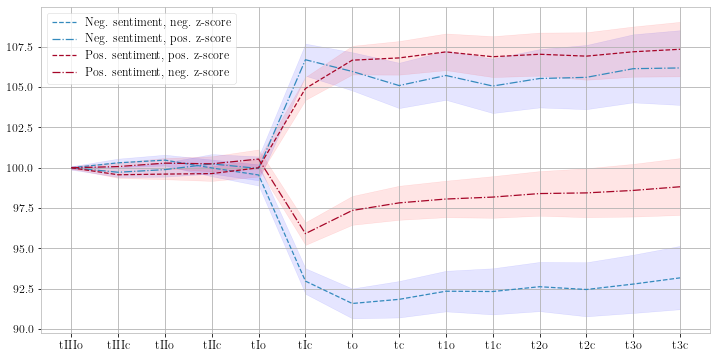

In [80]:
ex_post = False

period_start = datetime(2002,1,1)
period_end   = datetime(2019,12,31)

export      = False   # save to file
z_score_val = 1.0
filename = "event_study_oc_2002_2020_z_score_1_645_vix_below_20"

cases = {}
cases['Neg. sentiment, neg. z-score'] = ((df_oc.prediction_value <= -0.95) &
                                         (df_oc.z_tIc <= -z_score_val))
cases['Neg. sentiment, pos. z-score'] = ((df_oc.prediction_value <= -0.95) &
                                         (df_oc.z_tIc >= z_score_val))
cases['Pos. sentiment, pos. z-score'] = ((df_oc.prediction_value >= 0.95) &
                                         (df_oc.z_tIc >= z_score_val))
cases['Pos. sentiment, neg. z-score'] = ((df_oc.prediction_value >= 0.95) &
                                         (df_oc.z_tIc <= -z_score_val))


# linestyles
col0 = ["#348ABD", "#348ABD", "#A60628", "#A60628"]
col1 = ["b", "b", "r", "r"]
line = ["dashed", "dashdot", "dashed", "dashdot"]

#cases[5] = ((df_oc.prediction_value <= -0.95) &
#            (df_oc.z_to       <= -1.645)      &
#            (abs(df_oc.z_tIc) <=  0.5))

#cases['neg_sentiment'] = (df_oc.prediction_value <= -0.95) 
#cases['pos_sentiment'] = (df_oc.prediction_value >=  0.95)

#ticks = [col+t for col in r_cols for t in ['o', 'c']]

def get_price(case, ex_post, period_start, period_end):    
    if ex_post:
        df_sel = df_oc.loc[cases[case], 'to':'t6c']
    else:
        df_sel = df_oc.loc[cases[case], 'tIIIo':'t3c']
      
    ticks  = df_sel.columns
    df_sel = df_sel.loc[(slice(None), ((df_sel.index.get_level_values(1) >= period_start) & 
                                       (df_sel.index.get_level_values(1) <= period_end))), :]
    n = df_sel.shape[0]
    mean = df_sel.mean()
    mean[0] = 0
    std  = df_sel.std()
    std_err = std/np.sqrt(n)
    t_value = mean/std_err
    
    p  = (100*(mean+1).cumprod().values).astype(np.float32)
    pu = (100*(mean+std_err+1).cumprod().values).astype(np.float32)
    pl = (100*(mean-std_err+1).cumprod().values).astype(np.float32)
    return p, pu, pl, n, ticks, t_value


t_values = {}
fig, ax = plt.subplots(figsize=(12,6))
for j, case in enumerate(cases):
    p, pu, pl, n, ticks, t_value = get_price(case, ex_post, period_start, period_end)
    t_values[case] = t_value
    print(f'Observations Case {case}: {n}')
    ax.plot(ticks, p, linewidth=1.25, label=f"{case}", linestyle=line[j], color=col0[j])
    ax.fill_between(ticks, pu, pl, alpha=.1, color=col1[j]) 
plt.legend()
if export:
    plt.savefig(save_path+filename+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', dpi=100, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

In [81]:
pd.DataFrame.from_dict(t_values)

,"Neg. sentiment, neg. z-score","Neg. sentiment, pos. z-score","Pos. sentiment, pos. z-score","Pos. sentiment, neg. z-score"
tIIIo,0.000000,0.000000,0.000000,0.000000
tIIIc,1.890982,-1.565709,-3.013740,0.521484
tIIo,2.159954,1.131437,0.345067,3.370874
tIIc,-2.636725,2.105679,0.224598,-0.288995
tIo,-3.084140,-2.083879,4.116254,2.355861
tIc,-36.898988,32.777445,35.765017,-33.993129
to,-9.522892,-3.716560,10.438208,7.956815
tc,1.269628,-3.791026,0.925390,2.993075
t1o,4.137061,5.833046,4.056698,3.248432
t1c,-0.100482,-3.756606,-2.236179,0.759907


## 
### Descriptive Regressions

In [5]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

vix = pd.read_csv("C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/VIX.csv", encoding="utf-8")
vix.date = pd.to_datetime(vix.date)
vix = vix.set_index('date')

In [767]:
start_date = datetime(2002,1,1)
end_date   = datetime(2020,12,31)
filter_vix = False
volatile_dates = vix.loc[vix.vix >= 20].index
#volatile_dates = vix.loc[vix.vix <= 20].index
cases = {}
model = {}
y = ('to', 'return (open to close)')

def get_beta(x):
    return beta.loc[x.name[1], x.name[0]] 

sel_df_oc = df_oc.loc[(slice(None), ((df_oc.index.get_level_values(1) >= start_date) &  
                                     (df_oc.index.get_level_values(1) <  end_date))), :].copy()

if filter_vix:
    scaler = StandardScaler()
    scaler.fit(vix.loc[sel_df_oc.index.get_level_values(1)].values)
    sel_df_oc['vix'] = scaler.transform(vix.loc[sel_df_oc.index.get_level_values(1)].values)   
    sel_df_oc = sel_df_oc.loc[sel_df_oc.index.get_level_values(1).isin(volatile_dates)]


cases['Neg. sentiment, neg. z-score'] = ((sel_df_oc.prediction_value <= -0.9) &
                                         (sel_df_oc.z_tIc < 0))
cases['Neg. sentiment, pos. z-score'] = ((sel_df_oc.prediction_value <= -0.9) &
                                         (sel_df_oc.z_tIc > 0))
cases['Pos. sentiment, neg. z-score'] = ((sel_df_oc.prediction_value >= 0.9)  &
                                         (sel_df_oc.z_tIc < 0))
cases['Pos. sentiment, pos. z-score'] = ((sel_df_oc.prediction_value >= 0.9)  &
                                         (sel_df_oc.z_tIc > 0))


for case in cases.keys():   
    # Create sentiment dummy variable with the values -1, 1 and 0   
    #sel_df_oc.prediction_value = sel_df_oc.prediction_value.apply(lambda x: 1 if x >= 0.95 else -1 if x <= -0.95 else 0)  
    
    X_y = sel_df_oc.loc[cases[case]][[y[0], 'z_tIc', 'prediction_value']].astype('float64')
    X_y.columns = [y[1], 'z_score', 'sentiment']   # rename columns
    X_y.insert(1, 'intercept', 1)                  # add intercept
    
    # Data Imputation (use the mean for missing values)
    print(f"{X_y['z_score'].isna().sum()} z-scores and {X_y[y[1]].isna().sum()} returns are missing")
    X_y.loc[X_y.z_score.isna(), 'z_score'] = X_y.loc[~X_y.z_score.isna(), 'z_score'].mean()
    X_y.loc[X_y[y[1]].isna(), y[1]] = X_y.loc[~X_y[y[1]].isna(), y[1]].mean()
    
    X_y['sentiment^2']  =  X_y['sentiment']**2
    X_y['z_score^2']    =  X_y['z_score']**2
    X_y['cross-term']   = (X_y['z_score'] * X_y['sentiment'])
    X_y['cross-term^2'] = (X_y['z_score'] * X_y['sentiment'])**2
    X_y['vix']          = np.log(vix.loc[X_y.index.get_level_values(1)].values)
    X_y['beta']         = X_y.apply(get_beta, axis=1)
    
    #variables = ['intercept', 'z_score', 'sentiment', 'cross-term', 'z_score^2', 'sentiment^2', 'cross-term^2', 'vix', 'beta']
    #variables = ['intercept', 'cross-term', 'cross-term^2']
    variables = ['intercept', 'z_score']
    model[case] = sm.OLS(X_y[y[1]], X_y[variables]).fit()   
    
    
    
stargazer = MyStargazer([model['Neg. sentiment, neg. z-score'], 
                         model['Neg. sentiment, pos. z-score'],
                         model['Pos. sentiment, neg. z-score'],
                         model['Pos. sentiment, pos. z-score']])

stargazer.significant_digits(4)
stargazer.custom_columns(['Sentiment N, z-score N', 'Sentiment N, z-score P', 'Sentiment P, z-score N', 'Sentiment P, z-score P'], [1, 1, 1, 1])
stargazer.show_model_numbers(True)
stargazer.covariate_order(variables)
stargazer.show_degrees_of_freedom(False)
display(HTML(stargazer.render_html()))

0 z-scores and 2 returns are missing
0 z-scores and 1 returns are missing
0 z-scores and 2 returns are missing
0 z-scores and 0 returns are missing


In [551]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable:}} \
\cr \cline{4-5}
\\[-1.8ex] & \multicolumn{1}{c}{Sentiment N, z-score N} & \multicolumn{1}{c}{Sentiment N, z-score P} & \multicolumn{1}{c}{Sentiment P, z-score N} & \multicolumn{1}{c}{Sentiment P, z-score P}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 intercept & -0.0004$^{}$ & 0.0012$^{*}$ & 0.0006$^{}$ & -0.0004$^{}$ \\
  & (-0.6279) & (1.9509) & (1.3218) & (-1.1290) \\
 cross-term & 0.0006$^{}$ & 0.0042$^{***}$ & -0.0011$^{***}$ & -0.0004$^{}$ \\
  & (1.4121) & (9.1289) & (-2.8501) & (-1.4628) \\
\hline \\[-1.8ex]
 Observations & 10,869 & 10,336 & 12,382 & 13,740 \\
 $R^2$ & 0.0002 & 0.0080 & 0.0007 & 0.0002 \\
 Adjusted $R^2$ & 0.0001 & 0.0079 & 0.0006 & 0.0001 \\
 Residual Std. Error & 0.0470 & 0.0487 & 0.0323 & 0.0317  \\
 F Statistic & 1.9940$^{}$  & 83.3360$^{***}$  & 8.1231$^{***}$  & 2.1397$^{}$  \\


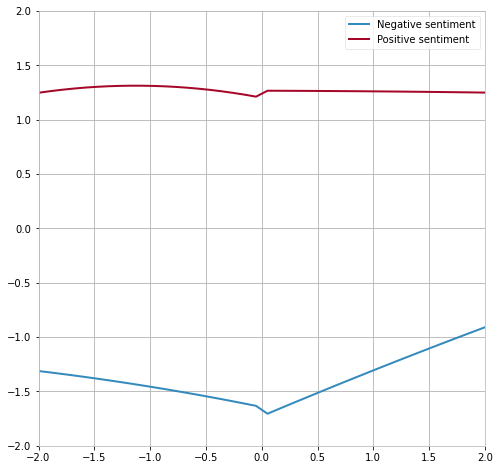

In [311]:
z_score_range = [(-2,0), (0,2)]
sentiment     = {'neg': -0.95, 'pos': 0.95}

k = 20
j = 0
y_pred = {}
#vix_value = 20
#x_vix = np.array([scaler.transform(np.array([vix_value]).reshape(1,-1))[0][0]]*k)

for s in sentiment.keys():
    y_pred[s] = np.array([])    
    for z in z_score_range:        
        z_vals = np.linspace(z[0], z[1], k)
        X_pred = np.c_[np.ones(k), z_vals*np.array([sentiment[s]]*k), (z_vals*np.array([sentiment[s]]*k))**2]
        y_pred[s] = np.hstack((y_pred[s], model[list(cases.keys())[j]].predict(X_pred)))       
        #print(f"Sentiment: {sentiment[s]}, z-scores: {z_vals}, model: {list(cases.keys())[j]}")
        j+=1
        


                
xaxis = np.linspace(z_score_range[0][0], z_score_range[-1][-1], 2*k)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(xaxis, y_pred['neg']*100, label='Negative sentiment')
ax.plot(xaxis, y_pred['pos']*100, label='Positive sentiment')
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
plt.legend()
plt.show()

Unconditional (No news events)

In [716]:
z_vals_file_open_to_close = f'z_values_127d_mo_to_mc_idiosync_abn_returns_mo_to_mc_excl_cond_2002-2021.csv'
z_vals_file_close_to_open = f'z_values_127d_mo_to_mc_idiosync_abn_returns_mc_to_mo_excl_cond_2002-2021.csv'

z_val_r_c = pd.read_csv(extended_model_path+z_vals_file_open_to_close, encoding='utf-8-sig') 
z_val_r_c = z_val_r_c.rename(columns = {'Unnamed: 0':'Ticker'})
z_val_r_c.Date = pd.to_datetime(z_val_r_c.Date)
z_val_r_c = z_val_r_c.set_index(['Ticker', 'Date']) 

z_val_r_o = pd.read_csv(extended_model_path+z_vals_file_close_to_open, encoding='utf-8-sig') 
z_val_r_o = z_val_r_o.rename(columns = {'Unnamed: 0':'Ticker'})
z_val_r_o.Date = pd.to_datetime(z_val_r_o.Date)
z_val_r_o = z_val_r_o.set_index(['Ticker', 'Date']) 

z_val_r_o = z_val_r_o[['z_value', 'return_t_1']]
z_val_r_o = z_val_r_o.rename(columns={'return_t_1':'return_t_1o'})
z_val_r_o = z_val_r_o.sort_index()

z_val_r_c = z_val_r_c[['z_value', 'return_t_1']]
z_val_r_c = z_val_r_c.rename(columns={'return_t_1':'return_t_1c'})
z_val_r_c = z_val_r_c.sort_index()

z_val_r = pd.concat([z_val_r_o, z_val_r_c['return_t_1c']], axis=1)

In [768]:
start_date = datetime(2002,1,1)
end_date   = datetime(2020,12,31)
filter_vix = False
volatile_dates = vix.loc[vix.vix >= 20].index
#volatile_dates = vix.loc[vix.vix <= 20].index
cases = {}
model2 = {}

y = ('return_t_1o', 'return (open to close)')

def get_beta(x):
    return beta.loc[x.name[1], x.name[0]] 

z_df = z_val_r[['z_value', y[0]]]
z_df = z_df.loc[((z_df.index.get_level_values(1) >= start_date) & (z_df.index.get_level_values(1) <  end_date)), :].copy()


if filter_vix:
    scaler = StandardScaler()
    scaler.fit(vix.loc[z_df.index.get_level_values(1)].values)
    z_df['vix'] = scaler.transform(vix.loc[z_df.index.get_level_values(1)].values)   
    z_df = z_df.loc[z_df.index.get_level_values(1).isin(volatile_dates)]

cases['Neg. z-score'] = (z_df.z_value < 0)
cases['Pos. z-score'] = (z_df.z_value > 0)


for case in cases.keys():      
    X_y = z_df.loc[cases[case]][[y[0], 'z_value']].astype('float64')
    X_y.columns = [y[1], 'z_score']   # rename columns
    X_y.insert(1, 'intercept', 1)     # add intercept
    X_y = X_y.dropna()                # remove missing values
    
    X_y['z_score^2']    = X_y['z_score']**2
    X_y['vix']          = np.log(vix.loc[X_y.index.get_level_values(1)].values)
    #X_y['beta']         = X_y.apply(get_beta, axis=1)
    
    variables = ['intercept', 'z_score']
    model2[case] = sm.OLS(X_y[y[1]], X_y[variables]).fit()   
    

stargazer = MyStargazer([model2['Neg. z-score'], 
                         model2['Pos. z-score']])

stargazer.significant_digits(4)
stargazer.custom_columns(['Neg. z-score', 'Pos. z-score'], [1, 1])
stargazer.show_model_numbers(True)
stargazer.covariate_order(variables)
stargazer.show_degrees_of_freedom(False)
display(HTML(stargazer.render_html()))

In [752]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & \multicolumn{1}{c}{Neg. z-score} & \multicolumn{1}{c}{Pos. z-score}  \\
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 intercept & -0.0001$^{***}$ & 0.0000$^{}$ \\
  & (-3.2323) & (1.2447) \\
 z_score & 0.0002$^{***}$ & -0.0006$^{***}$ \\
  & (5.6393) & (-16.8478) \\
\hline \\[-1.8ex]
 Observations & 996,222 & 1,003,177 \\
 $R^2$ & 0.0000 & 0.0003 \\
 Adjusted $R^2$ & 0.0000 & 0.0003 \\
 Residual Std. Error & 0.0243 & 0.0246  \\
 F Statistic & 31.8022$^{***}$  & 283.8475$^{***}$  \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


In [769]:
stargazer = MyStargazer([model['Neg. sentiment, neg. z-score'], 
                         model['Neg. sentiment, pos. z-score'],
                         model['Pos. sentiment, neg. z-score'],
                         model['Pos. sentiment, pos. z-score'],
                         model2['Neg. z-score'], 
                         model2['Pos. z-score']])

stargazer.significant_digits(4)
stargazer.custom_columns(['Sentiment N, z-score N', 'Sentiment N, z-score P', 'Sentiment P, z-score N', 'Sentiment P, z-score P', 'Neg. z-score', 'Pos. z-score'], [1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(True)
stargazer.covariate_order(variables)
stargazer.show_degrees_of_freedom(False)
display(HTML(stargazer.render_html()))

In [771]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent variable:}} \
\cr \cline{6-7}
\\[-1.8ex] & \multicolumn{1}{c}{Sentiment N, z-score N} & \multicolumn{1}{c}{Sentiment N, z-score P} & \multicolumn{1}{c}{Sentiment P, z-score N} & \multicolumn{1}{c}{Sentiment P, z-score P} & \multicolumn{1}{c}{Neg. z-score} & \multicolumn{1}{c}{Pos. z-score}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \\
\hline \\[-1.8ex]
 intercept & -0.0157$^{***}$ & -0.0160$^{***}$ & 0.0138$^{***}$ & 0.0130$^{***}$ & 0.0001$^{***}$ & -0.0002$^{***}$ \\
  & (-25.4837) & (-25.1518) & (26.8787) & (28.3014) & (5.6046) & (-12.8342) \\
 z_score & -0.0010$^{**}$ & 0.0029$^{***}$ & 0.0015$^{***}$ & -0.0004$^{}$ & -0.0004$^{***}$ & 0.0004$^{***}$ \\
  & (-2.2470) & (6.3809) & (3.3349) & (-1.2742) & (-16.9629) & (18.7897) \\
\hline \\[-1.8ex]
 Observations & 10,869 & 10,336 & 12,382 & 13,740 & 1,005,355 & 1,012,075 \\
 $R^

## 
### Predictive Regressions

In [187]:
# In-Sample
def make_prediction(x, barrier=0.95):
    X = np.c_[1, x.z_tIc*x.prediction_value, (x.z_tIc*x.prediction_value)**2]
    if x.prediction_value < -barrier:
        if x.z_tIc < 0:
            y_pred = model['Neg. sentiment, neg. z-score'].predict(X)[0]
        elif x.z_tIc > 0:
            y_pred = model['Neg. sentiment, pos. z-score'].predict(X)[0]
        else:
            y_pred = np.nan
            
    elif x.prediction_value > barrier:
        if x.z_tIc < 0:
            y_pred = model['Pos. sentiment, neg. z-score'].predict(X)[0]
        elif x.z_tIc > 0:
            y_pred = model['Pos. sentiment, pos. z-score'].predict(X)[0]
        else:
            y_pred = np.nan     
    else:
        y_pred = np.nan  
         
    return y_pred
    

df = df_oc.loc[:, ['prediction_value', 'z_tIc', 'tc']].copy()

df['y_pred'] = df.apply(make_prediction, axis=1)

In [203]:
true_neg = df.loc[df.y_pred < 0, 'tc'] < 0
true_pos = df.loc[df.y_pred > 0, 'tc'] > 0

print(f"Precision (neg): {true_neg.sum()/true_neg.shape[0]:.4f}")
print(f"Precision (pos): {true_pos.sum()/true_pos.shape[0]:.4f}")

Precision (neg): 0.5121
Precision (pos): 0.5037


In [202]:
print(f"mean neg.: {df.loc[df.prediction_value < 0, 'tc'].mean()*100:.4f}%")
print(f"mean pos.: {df.loc[df.prediction_value > 0, 'tc'].mean()*100:.4f}%")

mean neg.: -0.0619%
mean pos.: 0.0158%


In [199]:
print(f"mean neg.: {df.loc[df.y_pred < 0, 'tc'].mean()*100:.4f}%")
print(f"mean pos.: {df.loc[df.y_pred > 0, 'tc'].mean()*100:.4f}%")

mean neg.: -0.0929%
mean pos.: 0.1297%


# 
### Descriptive Statistics

1. Return Data

In [797]:
#interval   = 18
start_date = datetime(2002,1,1)
end_date   = datetime(2021,1,1)

Ticker_inSP = pd.read_csv(data_path+'Ticker_inSP_2020.csv', index_col=0)
Ticker_inSP.index = pd.to_datetime(Ticker_inSP.index)
Ticker_inSP_adj = pd.merge_asof(left=return_data.loc[:, []], right=Ticker_inSP, left_index=True, right_index=True, direction='backward')


returns_mo_to_mc = pd.Series(dtype='float32')
returns_mc_to_mo = pd.Series(dtype='float32')

for timestamp in tqdm(return_data.loc[start_date:end_date].index): 
    temp = return_data.loc[timestamp, set(return_data.columns).intersection(set(Ticker_inSP_adj.loc[timestamp].dropna()))]
    
    if return_data.loc[timestamp, 'interval'] == 'mo_to_mc':
        returns_mo_to_mc = pd.concat([returns_mo_to_mc, temp])   
    elif return_data.loc[timestamp, 'interval'] == 'mc_to_mo':
        returns_mc_to_mo = pd.concat([returns_mc_to_mo, temp])
        
        
returns_mo_to_mc.name = 'DAY'
returns_mc_to_mo.name = 'NIGHT'
plot_df = pd.concat([returns_mo_to_mc, returns_mc_to_mo], axis=1, join='outer').astype('float32')

  0%|          | 0/9474 [00:00<?, ?it/s]

Kernel Density estimation of return distributions
- https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

In [798]:
%%time
x = np.linspace(-0.15, 0.15, 5000)
densities = {}

def parrallel_score_samples(kde, samples, thread_count=int(0.875 * multiprocessing.cpu_count())):
    with multiprocessing.Pool(thread_count) as p:
        return np.concatenate(p.map(kde.score_samples, np.array_split(samples, thread_count)))
    
for col in plot_df.columns:
    X = plot_df[col].dropna().values.reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.001, atol=0.0005, rtol=0.01).fit(X)
    #logprob = kde.score_samples(x[:, None])
    logprob = parrallel_score_samples(kde, x[:, None])
    densities[col] = np.exp(logprob)

CPU times: total: 4.41 s
Wall time: 36 s


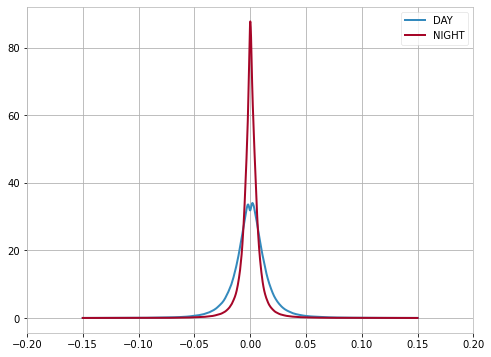

In [807]:
fig, ax = plt.subplots(figsize=(8,6))
col1, col2 = 'DAY', 'NIGHT'
ax = plt.plot(x, densities[col1], linewidth=2, label=col1)
ax = plt.plot(x, densities[col2], linewidth=2, label=col2)

plt.xlim(-0.075, 0.075)  
#plt.ylabel('Density', labelpad=15)
plt.legend()
plt.savefig(save_path+'return_density_day_vs_night_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Selecting the bandwidth via cross-validation (very slow)
from sklearn.model_selection import GridSearchCV

X = plot_df['DAY'].dropna().values[:, None]

#bandwidths = 10 ** np.linspace(-3, 0, 10)
bandwidths = np.array([0.001, 0.002, 0.003])
grid = GridSearchCV(KernelDensity(kernel='gaussian', atol=0.1), {'bandwidth': bandwidths})

grid.fit(X)
grid.best_params_

## 
Autocorrelation plot with market opening and market closing returns

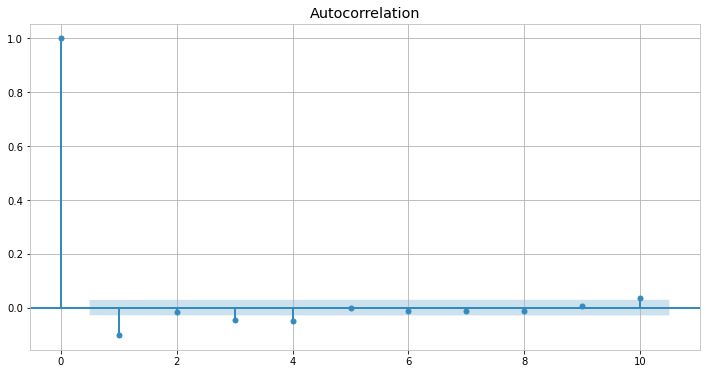

In [49]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12,6))
#plot_acf(return_data.F.dropna().values, lags=10, ax=ax)
plot_acf(return_data.loc[return_data.interval=='mc_to_mo', 'MLM':].mean(axis=1).dropna().values, lags=10, ax=ax)
plt.show()

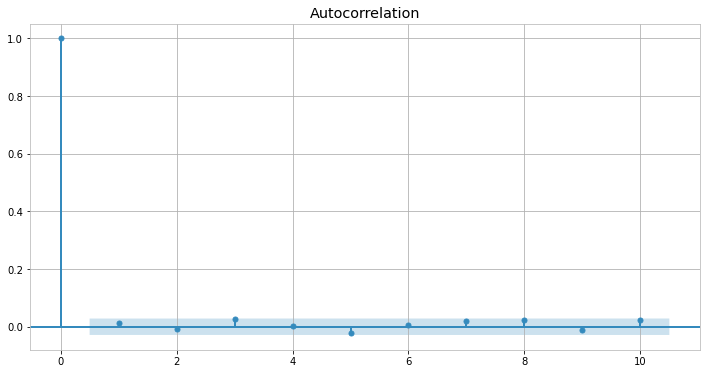

In [50]:
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(return_data.loc[return_data.interval=='mo_to_mc', 'MLM':].mean(axis=1).dropna().values, lags=10, ax=ax)
plt.show()

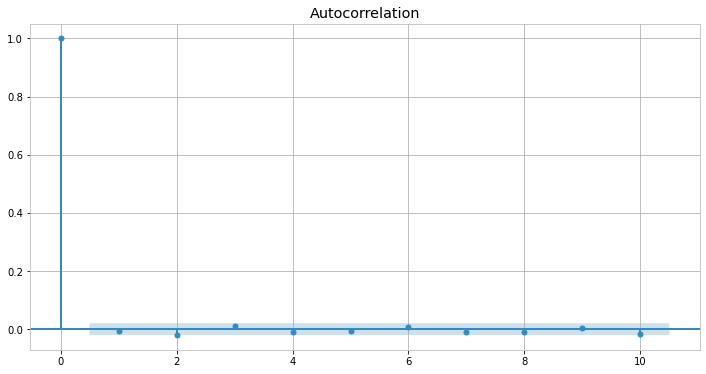

In [51]:
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(return_data.loc[:, 'MLM':].mean(axis=1).dropna().values, lags=10, ax=ax)
plt.show()

2. News Data

In [7]:
# Distinguish between trading and non-trading hours

open_time  = time(9,30)
close_time = time(16,0)

news_event_df['trading_hours'] = False
news_event_df.loc[(open_time < news_event_df.index.get_level_values(level=0).time) & 
                  (close_time > news_event_df.index.get_level_values(level=0).time), 'trading_hours'] = True

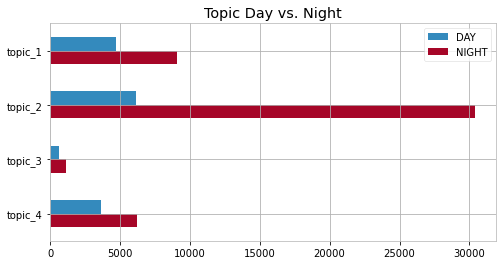

In [18]:
plot_df = pd.DataFrame()
#plot_df['DAY']   = news_event_df.loc[news_event_df.trading_hours == True, 'topic_1':'topic_4'].sum()
#plot_df['NIGHT'] = news_event_df.loc[news_event_df.trading_hours == False, 'topic_1':'topic_4'].sum()

plot_df['DAY']   = (news_event_df.loc[news_event_df.trading_hours == True, 'topic_1':'topic_4'] > 0.3).sum(axis=0)
plot_df['NIGHT'] = (news_event_df.loc[news_event_df.trading_hours == False, 'topic_1':'topic_4'] > 0.3).sum(axis=0)

fig, ax = plt.subplots(figsize=(8,4))
plot_df.plot.barh(ax=ax)
ax.invert_yaxis()
#plt.xlim(0, 25000)
plt.title("Topic Day vs. Night")
plt.show()

In [237]:
plot_df = pd.DataFrame()
plot_df['topic_1'] = [news_event_df.loc[(news_event_df.trading_hours == False) & (news_event_df.topic_1 > 0)].shape[0]]
plot_df['topic_2'] = [news_event_df.loc[(news_event_df.trading_hours == False) & (news_event_df.topic_2 > 0)].shape[0]]
plot_df['Other']   = [news_event_df.loc[(news_event_df.trading_hours == False) & (news_event_df.topic_1 == 0) & (news_event_df.topic_2 == 0)].shape[0]]



fig, ax = plt.subplots(figsize=(8,4))
plot_df.T.plot.barh(ax=ax, legend=False)
ax.invert_yaxis()
#plt.xlim(0, 25000)
ax.set_xlabel('Count', labelpad=15)
plt.title("Topic-count of Overnight News")
plt.show()

,topic_1,topic_2,Other


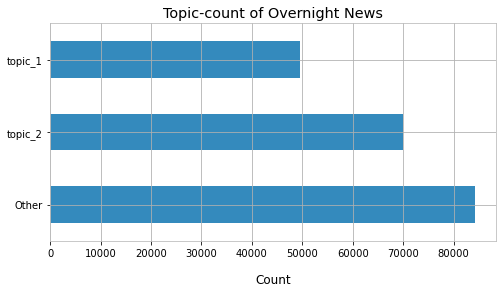

In [250]:
plot_df = pd.DataFrame()
plot_df['topic_1'] = [news_event_df.loc[(news_event_df.trading_hours == False) & (news_event_df.topic_1 > 0)].shape[0]]
plot_df['topic_2'] = [news_event_df.loc[(news_event_df.trading_hours == False) & (news_event_df.topic_2 > 0)].shape[0]]
plot_df['Other']   = [news_event_df.loc[(news_event_df.trading_hours == False) & (news_event_df.topic_1 == 0) & (news_event_df.topic_2 == 0)].shape[0]]

fig, ax = plt.subplots(figsize=(8,4))
plot_df.T.plot.barh(ax=ax, legend=False)
ax.invert_yaxis()
#plt.xlim(0, 25000)
ax.set_xlabel('Count', labelpad=15)
plt.title("Topic-count of Overnight News")
plt.show()

In [252]:
z_scores = pd.read_csv(data_path+f'z_values_mo_to_mc_127d_rw{idiosync}.csv', encoding='utf-8')      
z_scores.Date = pd.to_datetime(z_scores.Date)                                   
z_scores = z_scores.set_index('Date')
z_scores_mc_tI = z_scores.shift(1)

In [299]:
news_event_df = load_data(extended_model_path+'train_valid_data_pred_and_abn_returns_mo_to_mc_17_5h_z_val_idiosync_fresh_'+str(2002)+'-'+str(2021)+'.csv')
news_event_df = news_event_df.reset_index()
news_event_df.Date = pd.to_datetime(news_event_df.Date)
news_event_df.Timestamp_ET = pd.DatetimeIndex(news_event_df.Timestamp_ET).tz_localize(None)

In [300]:
# Add z-value of market close on day t-1
news_event_df.insert(6, 'z_value_mc_tI', np.nan)
news_event_df['z_value_mc_tI'] = news_event_df.apply(get_z_val, axis=1)

In [301]:
news_event_df.head(2)

,Ticker,Date,Timestamp_ET,News,Sentiment,freshness,z_value_mc_tI,topic_1,topic_2,topic_3,topic_4,neutral,negative,positive,Prediction,...,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8,z_value_t_III,z_value_t_II,z_value_t_I,z_value_t,z_value_t_1
0,DIS,2002-01-07,2002-01-07 16:28:06.983,disney shareholders renew suit over ovitz payo...,0.0,fresh,NaN,0.0,0.000000,0.0,0.000000,0.954279,0.018684,0.027037,0,...,-0.005437,-0.033163,-0.064432,0.035197,0.012096,-0.000138,0.045765,-0.025760,0.037316,NaN,NaN,NaN,NaN,NaN,NaN
1,XRX,2002-01-07,2002-01-07 16:40:01.416,text fitch affirms xerox ratings outlook is st...,0.0,fresh,NaN,0.0,0.193966,0.0,0.395062,0.901240,0.039803,0.058957,0,...,-0.000622,0.033708,-0.026919,0.041696,-0.005990,0.009757,0.081039,0.017904,0.013545,-0.049118,NaN,NaN,NaN,NaN,NaN


In [302]:
var = 'return_t_1' #'z_value_mc_tI'

values_topic1 = news_event_df.loc[(news_event_df.topic_1 > 0), var].reset_index(drop=True)
values_topic2 = news_event_df.loc[(news_event_df.topic_2 > 0), var].reset_index(drop=True)
values_other  = news_event_df.loc[(news_event_df.topic_1 == 0) & (news_event_df.topic_2 == 0), var].reset_index(drop=True)

In [307]:
plot_df = pd.concat([values_topic1, values_topic2, values_other], axis=1)
plot_df.columns = ['topic1', 'topic2', 'other'] 
plot_df.head()

,topic1,topic2,other
0,-0.026919,-0.026919,-0.064432
1,-0.066170,-0.026919,-0.147874
2,-0.026895,-0.066170,-0.082123
3,-0.112421,-0.048297,-0.112421
4,0.004296,-0.048297,-0.040846


In [310]:
%%time
x = np.linspace(-0.15, 0.15, 5000)
densities = {}

def parrallel_score_samples(kde, samples, thread_count=int(0.875 * multiprocessing.cpu_count())):
    with multiprocessing.Pool(thread_count) as p:
        return np.concatenate(p.map(kde.score_samples, np.array_split(samples, thread_count)))
    
for col in plot_df.columns:
    X = plot_df[col].dropna().values.reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01, atol=0.0005, rtol=0.01).fit(X)
    #logprob = kde.score_samples(x[:, None])
    logprob = parrallel_score_samples(kde, x[:, None])
    densities[col] = np.exp(logprob)

CPU times: total: 172 ms
Wall time: 7.76 s


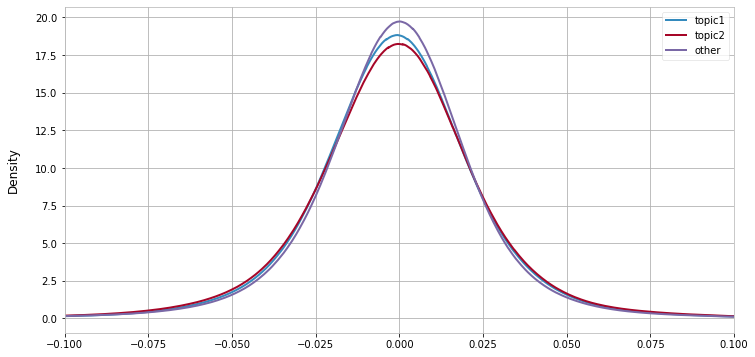

In [311]:
fig, ax = plt.subplots(figsize=(12,6))
col1, col2, col3 = 'topic1', 'topic2', 'other'
ax = plt.plot(x, densities[col1], linewidth=2, label=col1)
ax = plt.plot(x, densities[col2], linewidth=2, label=col2)
ax = plt.plot(x, densities[col3], linewidth=2, label=col3)

plt.xlim(-0.1, 0.1)  
plt.ylabel('Density', labelpad=15)
plt.legend()
#plt.savefig(save_path+'return_density_day_vs_night_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', bbox_inches='tight')
plt.show()

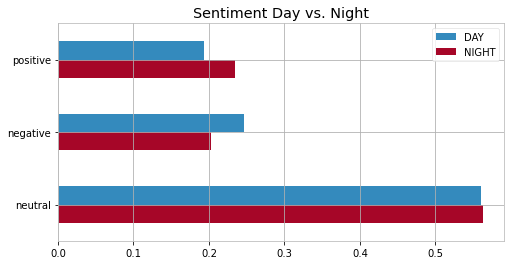

In [226]:
plot_df = pd.DataFrame()
plot_df['DAY']   = news_event_df.loc[news_event_df.trading_hours == True, ['positive', 'negative', 'neutral']].mean()
plot_df['NIGHT'] = news_event_df.loc[news_event_df.trading_hours == False, ['positive', 'negative', 'neutral']].mean()


fig, ax = plt.subplots(figsize=(8,4))
plot_df.plot.barh(ax=ax)
ax.invert_yaxis()
plt.title("Sentiment Day vs. Night")
plt.show()

Inspect News

In [ ]:
z_scores = pd.read_csv(data_path+f'z_values_mo_to_mc_127d_rw{idiosync}.csv', encoding='utf-8')      
z_scores.Date = pd.to_datetime(z_scores.Date)                                   
z_scores = z_scores.set_index('Date')
z_scores_mc_tI = z_scores.shift(1)

In [164]:
news_event_df = load_data(extended_model_path+'train_valid_data_pred_and_abn_returns_mo_to_mc_17_5h_z_val_idiosync_fresh_'+str(2002)+'-'+str(2021)+'.csv')
news_event_df = news_event_df.reset_index()
news_event_df.Date = pd.to_datetime(news_event_df.Date)
news_event_df.Timestamp_ET = pd.DatetimeIndex(news_event_df.Timestamp_ET).tz_localize(None)

print(news_event_df.shape)
news_event_df.head(2)

(128464, 34)


,Ticker,Date,Timestamp_ET,News,Sentiment,freshness,topic_1,topic_2,topic_3,topic_4,neutral,negative,positive,Prediction,prediction_value,...,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8,z_value_t_III,z_value_t_II,z_value_t_I,z_value_t,z_value_t_1
0,DIS,2002-01-07,2002-01-07 16:28:06.983,disney shareholders renew suit over ovitz payo...,0.0,fresh,0.0,0.000000,0.0,0.000000,0.954279,0.018684,0.027037,0,0.008352,...,-0.005437,-0.033163,-0.064432,0.035197,0.012096,-0.000138,0.045765,-0.025760,0.037316,NaN,NaN,NaN,NaN,NaN,NaN
1,XRX,2002-01-07,2002-01-07 16:40:01.416,text fitch affirms xerox ratings outlook is st...,0.0,fresh,0.0,0.193966,0.0,0.395062,0.901240,0.039803,0.058957,0,0.019154,...,-0.000622,0.033708,-0.026919,0.041696,-0.005990,0.009757,0.081039,0.017904,0.013545,-0.049118,NaN,NaN,NaN,NaN,NaN


In [165]:
# Add z-value of market close on day t-1
news_event_df.insert(3, 'z_value_mc_tI', np.nan)
news_event_df['z_value_mc_tI'] = news_event_df.apply(get_z_val, axis=1)

In [166]:
sel_cols = ['Ticker', 'Timestamp_ET', 'News', 'freshness', 'topic_1', 'topic_2', 'prediction_value', 'return_t', 'return_t_1', 'return_t_2', 'z_value_mc_tI']

data = news_event_df[sel_cols]
data = data.set_index('Timestamp_ET')

In [167]:
data.head(2)

,Ticker,News,freshness,topic_1,topic_2,prediction_value,return_t,return_t_1,return_t_2,z_value_mc_tI
Timestamp_ET,,,,,,,,,,
2002-01-07 16:28:06.983,DIS,disney shareholders renew suit over ovitz payo...,fresh,0.0,0.000000,0.008352,-0.033163,-0.064432,0.035197,NaN
2002-01-07 16:40:01.416,XRX,text fitch affirms xerox ratings outlook is st...,fresh,0.0,0.193966,0.019154,0.033708,-0.026919,0.041696,NaN


In [217]:
barrier = 0.95
z_score = 1.645

# Negative news on day t and significantely negative z-value on day t 
Case_1 = data.loc[(data.Ticker == 'INTC')            &
                  (data.prediction_value <= barrier) &
                  (data.z_value_mc_tI    <= -z_score), :].reset_index(drop=False)

In [218]:
Case_1

,Timestamp_ET,Ticker,News,freshness,topic_1,topic_2,prediction_value,return_t,return_t_1,return_t_2,z_value_mc_tI
0,2002-11-25 22:18:03.380,INTC,stocks rise amd jumps on intel price hike inte...,fresh,0.120690,0.000000,0.986965,-0.007256,-0.017926,NaN,-1.846158
1,2007-07-12 09:14:40.655,INTC,research alert banc of america raises intel pr...,fresh,0.341379,0.193966,0.996024,0.038553,0.003684,0.005538,-2.146543
2,2012-01-19 20:04:52.865,INTC,brief intel shares up percent after the bell i...,stale,0.103448,0.331897,0.995623,0.027763,0.026733,0.031526,-2.465404
3,2016-01-14 18:42:58.306,INTC,intel revenue rises marginally brief intel rep...,fresh,0.179310,0.353448,0.970510,0.048052,NaN,-0.024525,-2.843241


In [219]:
i = 2
Case_1.iloc[i]

Timestamp_ET                               2012-01-19 20:04:52.865000
Ticker                                                           INTC
News                brief intel shares up percent after the bell i...
freshness                                                       stale
topic_1                                                      0.103448
topic_2                                                      0.331897
prediction_value                                             0.995623
return_t                                                     0.027763
return_t_1                                                   0.026733
return_t_2                                                   0.031526
z_value_mc_tI                                               -2.465404
Name: 2, dtype: object

In [220]:
Case_1.News[i]

'brief intel shares up percent after the bell intel quarterly revenue forecast meets expectations brief intel results update intel boosts capex beats tempered expectations intel says expects drive shortage impact new york jan intel corp shares were up percent after the bell as it reported results revenue also meets expectations gaap eps cents shares up after earnings report san francisco jan intel corp forecast quarterly revenue in line with wall street expectations as shortage of hard drives disrupts pc production in market already hobbled by shaky economy and growing preference for tablets intel said revenue in the current quarter would be billion plus or minus million analysts on average had expected current quarter revenue of billion according to thomson reuters the world leading chipmaker said revenue in the fourth quarter was billion up percent and slightly higher than the billion expected gaap net income in the fourth quarter was billion up percent gaap earnings per share were c